In [1]:
# set up the environment
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess

In [2]:
df = pd.read_csv("../data/phages_per_genome.tsv.gz", delimiter='\t', compression='gzip')
df.head()

,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16.0,2.0,1.0,13.0,48916.0
1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31.0,1.0,10.0,20.0,40297.0
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38.0,6.0,13.0,19.0,268081.0
3,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46.0,6.0,11.0,29.0,166286.0
4,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33.0,3.0,9.0,21.0,93416.0


# Which Version Are You Using?

In [3]:
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {df.shape[0]:,} genomes parsed")

Please note that this was run with git commit 156f626 that has 38,601 genomes parsed


In [4]:
# this should be fixed in the next release and could be removed.
df = df.replace([np.nan], 0)

In [5]:
df['fraction pp'] = df['bp prophage']/df['Genome length']

## Compare genome length and prophage bp

Use statistics!

In [6]:
exog = sm.add_constant(df["Genome length"])
model = sm.OLS(df["bp prophage"], exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bp prophage   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 2.428e+04
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:44:12   Log-Likelihood:            -4.8604e+05
No. Observations:               38601   AIC:                         9.721e+05
Df Residuals:                   38599   BIC:                         9.721e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.501e+04    913.486    -27.378      0.000   -2.68e+04   -2.32e+04
Genome length     0.0341      0.000    155.817      0.000       0.034       0.035
==============================================================================
Omnibus:                     7494.464   Durbin-Watson:                   1.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37047.832
Skew:                           0.859   Prob(JB):                         0.00
Kurtosis:                       7.481   Cond. No.                     1.05e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
print(f"The equation is {model.params['Genome length']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for genome length is {model.pvalues['Genome length']:.3f}")

The equation is 0.034x + -25009.591
The R-squared is 0.386
The p-value for genome length is 0.000


In [8]:
df['bp pp fit'] = (model.params['Genome length'] * df['Genome length']) + model.params['const']

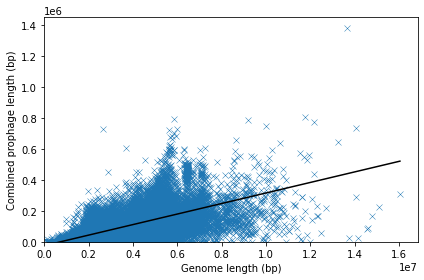

In [9]:
ax = sns.scatterplot(x='Genome length', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Genome length', y='bp pp fit', data=df, color='k')
ax.set_ylabel('Combined prophage length (bp)')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/lengths.png')

## Compare number of prophages and genome length

In [10]:
exog = sm.add_constant(df["Genome length"])
keptmodel = sm.OLS(df["Kept"], exog).fit()
keptmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Kept   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                 1.879e+04
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:44:19   Log-Likelihood:                -98080.
No. Observations:               38601   AIC:                         1.962e+05
Df Residuals:                   38599   BIC:                         1.962e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7866      0.039    -19.946      0.000      -0.864      -0.709
Genome length  1.294e-06   9.44e-09    137.074      0.000    1.28e-06    1.31e-06
==============================================================================
Omnibus:                    10056.595   Durbin-Watson:                   1.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46214.788
Skew:                           1.201   Prob(JB):                         0.00
Kurtosis:                       7.792   Cond. No.                     1.05e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
print(f"The equation is {keptmodel.params['Genome length']}x + {keptmodel.params['const']:.3f}")
print(f"The R-squared is {keptmodel.rsquared:.3f}")
print(f"The p-value for genome length is {keptmodel.pvalues['Genome length']:.3f}")

The equation is 1.293939726722593e-06x + -0.787
The R-squared is 0.327
The p-value for genome length is 0.000


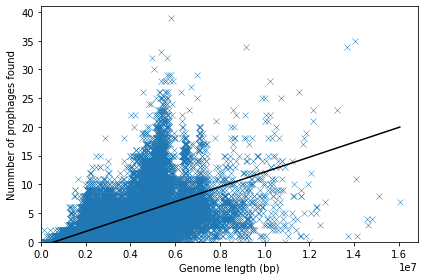

In [12]:
df['kept fit'] = (keptmodel.params['Genome length'] * df['Genome length']) + keptmodel.params['const']
ax = sns.scatterplot(x='Genome length', y='Kept', data=df, marker='x')
sns.lineplot(x='Genome length', y='kept fit', data=df, color='k')
ax.set_ylabel('Nummber of prophages found')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/num_kept.png')

## Compare number of prophages and total prophage bp

This bloody ought to be +ve!

The equation is 21893.898x + 14240.638
The R-squared is 0.815
The p-value for number of phages kept is 0.000


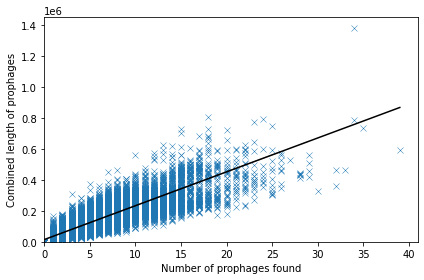

In [13]:
exog = sm.add_constant(df["Kept"])
keptvlen = sm.OLS(df["bp prophage"], exog).fit()
print(f"The equation is {keptvlen.params['Kept']:.3f}x + {keptvlen.params['const']:.3f}")
print(f"The R-squared is {keptvlen.rsquared:.3f}")
print(f"The p-value for number of phages kept is {keptvlen.pvalues['Kept']:.3f}")
df['kept vs bp fit'] = (keptvlen.params['Kept'] * df['Kept']) + keptvlen.params['const']
ax = sns.scatterplot(x='Kept', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Kept', y='kept vs bp fit', data=df, color='k')
ax.set_ylabel('Combined length of prophages')
ax.set_xlabel('Number of prophages found')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/keptpplen.png')

### Is there a relationship between # contigs and # phages?

This could be a relationship, especially as a genome gets fragmented.

In [14]:
exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs total pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']

exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs kept pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']


For TOTAL prophages
The equation is 0.185x + 22.155
The R-squared is 0.222
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is 0.001x + 4.093
The R-squared is 0.001
The p-value for number of phages kept is 0.000


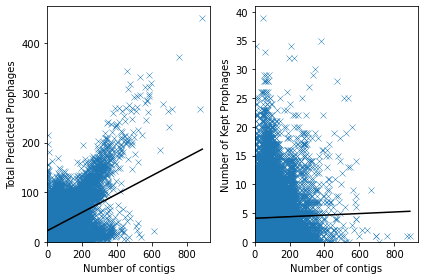

In [15]:
fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=df, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=df, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=df, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=df, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/contigspp.png')

#### Repeating, but only for genomes > 10 contigs

I think the graph is being strongly skewed at the bottom.


For TOTAL prophages in draft genomes > 20 contigs
The equation is 0.185x + 22.269 and r**2=0.194

For KEPT prophages
The equation is -0.004x + 4.814 and r**2=0.004


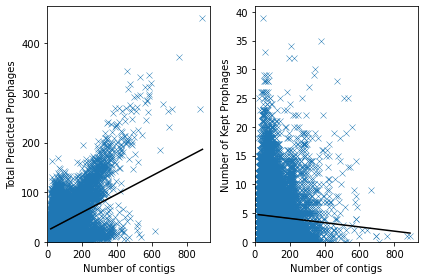

In [30]:
ndraft = 20
dfdrafts = df[df['Contigs'] > ndraft].copy()
dfdrafts.drop(['contigs vs kept pp', 'contigs vs total pp'], axis=1)
exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Total Predicted Prophages"], exog).fit()
print(f"\nFor TOTAL prophages in draft genomes > {ndraft} contigs")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f} and r**2={model.rsquared:.3f}")

dfdrafts['contigs vs total pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f} and r**2={model.rsquared:.3f}")
dfdrafts['contigs vs kept pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=dfdrafts, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=dfdrafts, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=dfdrafts, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=dfdrafts, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/draftcontigspp.png')

## Some general data about the prophages

In [16]:
print(f"There are {df['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {df['bp prophage'].mean():,.0f} bp, so {df['bp prophage'].mean()/df['Kept'].mean():,.0f} bp per prophage")

There are 4.18 prophages per genome on average, with a mean combined length of 105,669 bp, so 25,304 bp per prophage


In [17]:
print(f"The most prophages is {max(df['Kept'])} in {df.iloc[df['Kept'].argmax()]['Contig']}")
print(f"The longest combined amount of prophage DNA is {max(df['bp prophage'])} in {df.iloc[df['bp prophage'].argmax()]['Contig']}")
print(f"The highest fraction of prophage DNA is {max(df['fraction pp']) * 100:.3f}% in {df.iloc[df['fraction pp'].argmax()]['Contig']}")

The most prophages is 39.0 in GCA_002999675.1_ASM299967v1_genomic.gbff.gz
The longest combined amount of prophage DNA is 1381126.0 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The highest fraction of prophage DNA is 27.824% in GCA_000689355.1_PRJEB5999_assembly_1_genomic.gbff.gz


Text(0.5, 0, 'Number of prophages identified')

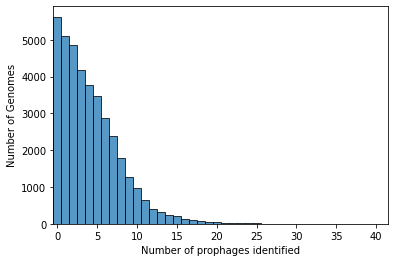

In [32]:
ax = sns.histplot(df['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")

# Filtered Data Set

Lets filter out anything in more than 10 contigs. This should be essentially complete genomes and remove any bias from fragmented genomes

In [33]:
filtermax=10
print(f"Before filtering we have {df.shape[0]:,} genomes")
fdf = df[df['Contigs'] < filtermax].copy()
fdf.reset_index().drop('index', axis=1)
print(f"After filtering for genomes with less than {filtermax} contigs we have {fdf.shape[0]:,} genomes")

Before filtering we have 38,601 genomes
After filtering for genomes with less than 10 contigs we have 6,922 genomes


In [20]:
print(f"After filtering for genomes with less than {filtermax} contigs")
print(f"There are {fdf['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {fdf['bp prophage'].mean():,.0f} bp, so {fdf['bp prophage'].mean()/fdf['Kept'].mean():,.0f} bp per prophage")

After filtering for genomes with less than 10 contigs
There are 3.42 prophages per genome on average, with a mean combined length of 111,741 bp, so 32,632 bp per prophage


In [21]:
print(f"The most prophages is {max(fdf['Kept'])} in {fdf.iloc[fdf['Kept'].argmax()]['Contig']}")
print(f"The longest combined amount of prophage DNA is {max(fdf['bp prophage'])} in {fdf.iloc[fdf['bp prophage'].argmax()]['Contig']}")
print(f"The highest fraction of prophage DNA is {max(fdf['fraction pp']) * 100:.3f}% in {fdf.iloc[fdf['fraction pp'].argmax()]['Contig']}")

The most prophages is 34.0 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The longest combined amount of prophage DNA is 1381126.0 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The highest fraction of prophage DNA is 27.824% in GCA_000689355.1_PRJEB5999_assembly_1_genomic.gbff.gz


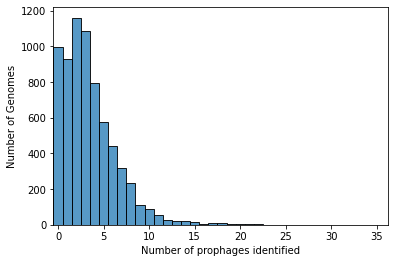

In [22]:
ax = sns.histplot(fdf['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")
fig = ax.get_figure()
fig.savefig('images/pp_hist.png')

### There is no dependency on number of contigs now

When we drop highly fragmented (draft) genomes, we loose the dependency on the number of contigs completely.


For TOTAL prophages
The equation is 0.416x + 22.397
The R-squared is 0.004
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is 0.089x + 3.162
The R-squared is 0.005
The p-value for number of phages kept is 0.000


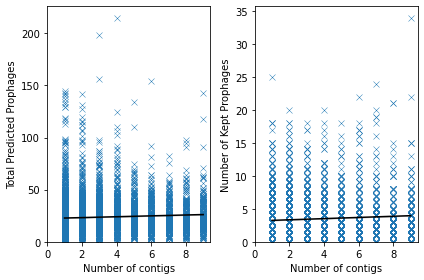

In [23]:
fdf.drop(['contigs vs total pp', 'contigs vs kept pp'], axis=1)

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs total pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs kept pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=fdf, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=fdf, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=fdf, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=fdf, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/filteredcontigspp.png')